In [1]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os
import dimod
import networkx as nx
import dwave_networkx as dnx

from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
import geopandas as gpd
from minorminer import find_embedding


from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')


def set_params_array(paramsdict):
    paramsarray = np.array([list(paramsdict.keys()), list(paramsdict.values())])
    return paramsarray

def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

Use the Zephyr system as your DWave sampler.

In [2]:

# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


Find all available nodes and couplers. Create the target, idealized Zephyr graph to be able to embed things later on.

In [3]:
#get the couplers and nodes available in the qpu
couplers_avail = np.array(sampler.edgelist)
nodes_avail = np.array(sampler.nodelist)

target_graph = nx.Graph()
target_graph.add_nodes_from(nodes_avail)
target_graph.add_edges_from(couplers_avail)

# context

When Ising spins are coupled to dynamical triangulations (only triangles, and some vertices are connected to $n_i$ other vertices, with the average $\langle n_i \rangle = 6$), this represents a model of two dimensional quantum gravity coupled to a matter field. The Ising spins are positioned on the vertices.

The partition function of such a model is 

\begin{equation}
    Z = \sum_{\{\mathcal{T}\}} e^{-\beta H(\mathcal{T},\{\sigma_i^z\})}
\end{equation}

where $\mathcal{T}$ denotes a given random triangulation with edges $\mathcal{E}$ and nodes (vertices) $\mathcal{V}$. One has the usual nearest-neighbor ferromagnetic Ising model on the triangulation $\mathcal{T}$, such that:

\begin{equation}
    H(\mathcal{T},\{\sigma_i^z\}) = -J \sum_{\langle i,j \rangle \in \mathcal{E}} \sigma_i^z \sigma_j^z- \sum_{i \in \mathcal{V}} h_i \sigma_i^z
\end{equation}

Without loss of generality, $|J|=1$ is set. The goal of this notebook is to study the magnetization, energy and susceptibility of this model using forward annealing on the D-Wave prototype device using the Zephyr graph. Embedding of a random triangulation is done with $N$ vertices. Annealings are tuned so that $B(s=1) = \beta$, and we can probe the lowest temperature $\beta = 1$ as well as the highest temperature $\beta = 0.01$. The simulations for a given $\beta$ should consist of $N_{\rm reads} = M$ reads for a given random triangulation, and then of $N_{\rm triang} = M$ random triangulations (all different embeddings). We can choose $M = 100$ for now for this preliminary notebook. Hopefully from the results we would be able to extract the critical exponents (scaling of observable with respect to $N$).

Note that the code is written very generally in order to accomodate boundary $h$ fields on the random triangulation, since a lot of research has been written on this.

How do we generate random triangulation? $N$ points are uniformly chosen in a square, and a Voronoi set and Delaunay triangulation. This graph of edges and nodes is then embedded into D-Wave's Zephyr QPU, while specifying that the found embedding should have ferromagnetic chains of at most length 2. This process then looks like this:

![image info](./figures/random%20triangulation.jpg)

# functions

Functions to automatically return the random triangulation's delaunay graph, as well as the boundary nodes of the planar graph.

In [4]:
def random_triangulation(Npts):
    polygon = Polygon([[0,0],[0,2],[2,2],[2,0],[0,0]])
    gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])

    #random points in box
    x,y = Random_Points_in_Bounds(polygon, Npts)
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['points'] = df['points'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='points')

    coordinates = np.column_stack((gdf_points.points.x, gdf_points.points.y))

    #voronoi boxes
    cells, generators = voronoi_frames(coordinates, clip="convex hull")

    #construct delaunay triangulation from the voronoi boxes
    delaunay = weights.Rook.from_dataframe(cells)

    # Once the graph is built, we can convert the graphs to networkx objects using the
    # relevant method.
    graph = delaunay.to_networkx()

    #if you want to remove dangling bonds:
    filter_delaunay_graph = graph.copy()

    for node in graph.nodes():
        if len(list(graph.edges(node))) == 1:
            filter_delaunay_graph.remove_node(node)

    return filter_delaunay_graph

def find_edge_of_graph(graph):

    three_cycles = []
    for node in graph.nodes():
    # for node in [0]:
        #neighborhood
        current_cycle = np.ones(3, dtype=int)
        current_cycle[0] = node
        neighbors = [item[1] for item in graph.edges(node)]
        # print(node)
        # print(neighbors)
        for edge_nn in graph.edges(node):
            # print('new edge')
            # print(edge_nn)
            cond = True
            it = 0
            next_neighbor = list(graph.edges(edge_nn[1]))
            # print(next_neighbor)
            # print('3-cycles',three_cycles)
            while cond == True and it < len(next_neighbor):
                edge_next = next_neighbor[it]
                it += 1
                # print(edge_next)
                # print('')
                if edge_next[1] != node and edge_next[1] in neighbors:
                    current_cycle[1] = edge_next[0]
                    current_cycle[2] = edge_next[1]
                    cond = False

                if tuple(np.sort(current_cycle)) in three_cycles:
                    cond = True

            # print(current_cycle)
            # if it < len(next_neighbor):
            three_cycles.append(tuple(np.sort(current_cycle)))

    three_cycles_filter = np.unique(np.array(three_cycles),axis =0)
    all_edges_from_three_cycles = []
    for k in range(len(three_cycles_filter)):
        ordered_list = three_cycles_filter[k]
        for l in range(3):
            all_edges_from_three_cycles.append(np.sort([ordered_list[l % 3], ordered_list[(l+1)%3]]))

    arr, counts = np.unique(np.array(all_edges_from_three_cycles),axis =0, return_counts=True)
    boundary_edge = []
    num = 0
    for k in range(len(counts)):
        if counts[k] == 1:
            boundary_edge.append(arr[k])
            num +=1

    return np.unique(np.array(boundary_edge).flatten()), np.unique(np.array(boundary_edge))

Functions for full embedding and dictionaries. Note that they currently **assume** a max chain length of 2, though it could be generalized to larger chains. 

In [43]:
def enumerate_edges_in_common(nodes, embedding):
    edges = []
    for k1 in embedding[nodes[0]]:
        for k2 in embedding[nodes[1]]:
            edges.append((k1,k2))
    return edges

def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup


#this function takes in 
# a sampler (defined up top)
# a delaunay graph (random instance)
# the associated boundary_nodes set
# the h val in bulk and boundary, and J interaction and K FM coupling, beta

def return_dicts(sampler, delaunay_graph, boundary_nodes, h_val, h_boundary, Jval, Kval, beta):

    condition_embed = True
    k = 1
    while condition_embed:
        # embedding = find_embedding(delaunay_graph, sampler.edgelist, random_seed = k)
        embedding = find_embedding(delaunay_graph, sampler.edgelist)
        k += 1
        if len(embedding) != 0:
            max_chain_length = np.max([len(item) for item in embedding.values()])
            # print('max chain length', max_chain_length)
            num_qubits = len(sum(list(embedding.values()), []))

            if max_chain_length < 4:
                print(k,'good embedding, {:.0f} qubits used'.format(num_qubits), flush=True)
                condition_embed = False
            else:
                print(k, 'bad embedding, {:.0f} qubits used'.format(num_qubits), flush=True)
        else:
            print(k, 'bad empty embedding', flush=True)

    h_dict = {}
    J_dict = {}

    for node in delaunay_graph.nodes():
        for emb in embedding[node]:
            if node in boundary_nodes:
                h_dict.update({emb:beta*h_boundary/len(embedding[node])})
            #this finds whether it is an edge or a bulk node
            else:
                h_dict.update({emb:beta*h_val/len(embedding[node])})

    for edge in delaunay_graph.edges():
        # print(edge)
        test_edges = enumerate_edges_in_common(edge, embedding)
        # print(test_edges)
        filter_test_edges = []
        # print(test_edges)
        for ed in test_edges:
            if ed in sampler.edgelist:
                filter_test_edges.append(ed)
            elif Reverse(ed) in sampler.edgelist:
                filter_test_edges.append(ed)
        # print(filter_test_edges)
        for it in range(len(filter_test_edges)):
            J_dict.update({filter_test_edges[it]:beta*Jval/len(filter_test_edges)})

    for local_embed in embedding.keys():
        emb_len = len(embedding[local_embed])
        if emb_len > 1:
            to_add_K = []
            for i in range(emb_len):
                for j in range(emb_len):
                    #print(tuple(embedding[local_embed]))
                    edge_K = (embedding[local_embed][i], embedding[local_embed][j])
                    if edge_K in sampler.edgelist:
                        # J_dict.update({edge_K:Kval})
                        to_add_K.append(edge_K)
                    elif Reverse(edge_K) in sampler.edgelist:
                        # J_dict.update({edge_K:Kval})
                        to_add_K.append(edge_K)
            final_to_add_K = [*set(to_add_K)]
            for ed in final_to_add_K:
                J_dict.update({ed:Kval})
    
    return h_dict, J_dict, embedding

# EX: random triangulation

First, an example of a random triangulation.

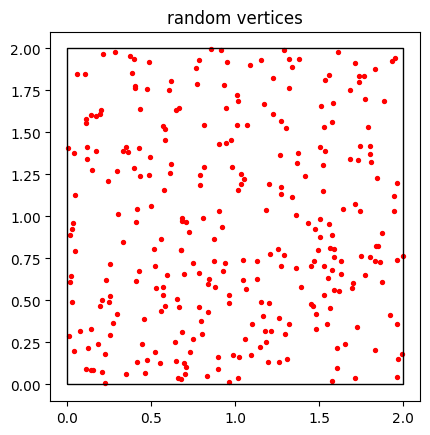

In [6]:
# polygon = Polygon([[0,0],[0,2],[1.5,1],[0.5,-0.5],[0,0]])
#a square
polygon = Polygon([[0,0],[0,2],[2,2],[2,0],[0,0]])
gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])

#random points in box
x,y = Random_Points_in_Bounds(polygon, 300)
df = pd.DataFrame()
df['points'] = list(zip(x,y))
df['points'] = df['points'].apply(Point)
gdf_points = gpd.GeoDataFrame(df, geometry='points')
# gdf_points = gpd.GeoDataFrame(df, geometry=GeoSeries)

#join and add to frame
Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# Keep points in "myPoly"
pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# Plot result
import matplotlib.pyplot as plt
base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
pnts_in_poly.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.title('random vertices')
plt.show()

Then, from these points, perform the voronoi polygons and obtain the delaunay triangulation, which is outputed. This is our random triangulation.

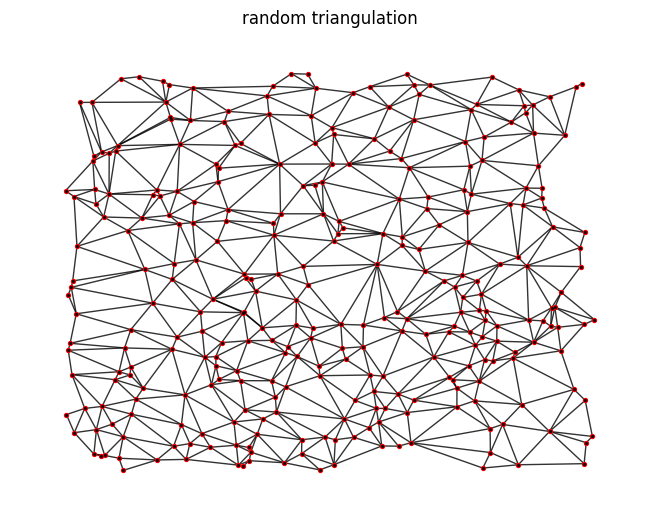

In [7]:
#point coordinates
coordinates = np.column_stack((gdf_points.points.x, gdf_points.points.y))

#voronoi boxes
cells, generators = voronoi_frames(coordinates, clip="convex hull")

#construct delaunay triangulation from the voronoi boxes
delaunay = weights.Rook.from_dataframe(cells)

# Once the graph is built, we can convert the graphs to networkx objects using the
# relevant method.
delaunay_graph = delaunay.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(delaunay_graph.nodes, coordinates))

# Now, we can plot with a nice basemap.
# ax = cells.plot(facecolor="lightblue", alpha=0.50, edgecolor="cornsilk", linewidth=2)
# ax.axis("off")
nx.draw(
    delaunay_graph,
    positions,
    node_size=2,
    node_color="k",
    edge_color="k",
    alpha=0.8,
)
# gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
plt.scatter(pnts_in_poly.points.x, pnts_in_poly.points.y,  color="red", s=8)
plt.title('random triangulation')
plt.show()

Example for a given $N$ number of points.

Text(0.5, 1.0, 'random triangulation with 300 points')

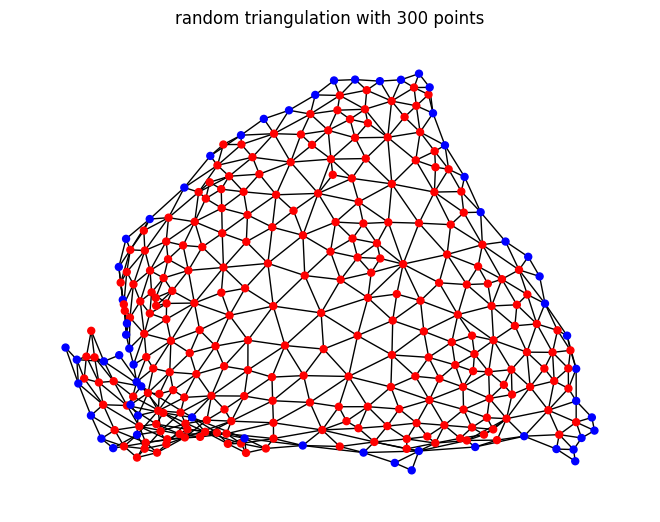

In [31]:
Npts = 300
delaunay_graph = random_triangulation(Npts)
boundary_nodes, boundary_edge = find_edge_of_graph(delaunay_graph)

node_colors = []
for node in delaunay_graph.nodes():
    if node in boundary_nodes:
        node_colors.append('blue')
    else:
        node_colors.append('red')

# spring layout for easier visual
pos=nx.spring_layout(delaunay_graph, k=1, iterations=1000, dim = 2)
nx.draw(delaunay_graph, pos, node_size = 25, node_color = node_colors)
plt.title('random triangulation with {:.0f} points'.format(Npts))

Show how this particular graph can be embedded onto the Zephyr. Try iteratively to have **max chain length** of 2. 

In [23]:
condition_embed = True
k = 1
while condition_embed:
    embedding = find_embedding(delaunay_graph, target_graph)
    k += 1
    if len(embedding) != 0:
        max_chain_length = np.max([len(item) for item in embedding.values()])
        print('max chain length', max_chain_length)
        num_qubits = len(sum(list(embedding.values()), []))

        if max_chain_length < 4:
            print(k,'good embedding, {:.0f} qubits used'.format(num_qubits))
            condition_embed = False
        else:
            print(k, 'bad embedding, {:.0f} qubits used'.format(num_qubits))
    else:
        print(k, 'bad empty embedding', flush=True)


max chain length 3
2 good embedding, 438 qubits used


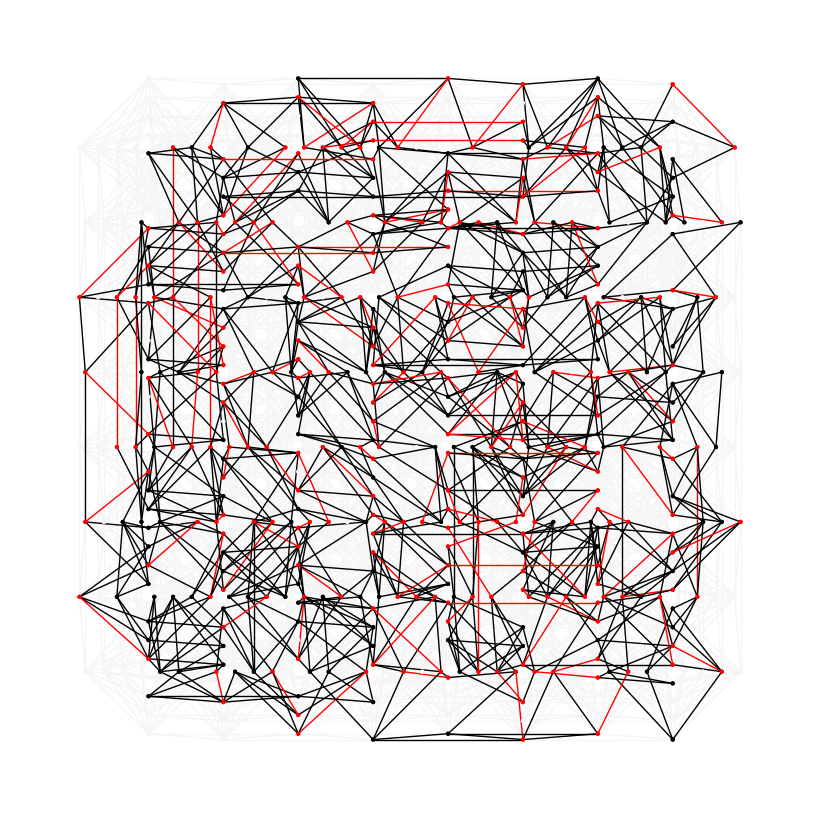

In [24]:
G = dnx.zephyr_graph(4)
plt.figure(figsize=(8,8))
chain_colors = {}
for key in embedding.keys():
    if len(embedding[key]) == 1:
        chain_colors.update({key:'black'})
    else:
        chain_colors.update({key:'red'})

dnx.draw_zephyr_embedding(G, emb = embedding, embedded_graph = delaunay_graph, unused_color = 'whitesmoke', chain_color = chain_colors, node_size = 4)

How many qubits do we need for a triangulation of $N$ vertices?

In [9]:
N_list = [10, 30, 50, 80, 100, 125, 150]
qubit_number_avg = []
qubit_number_std = []
N_rep = 20
limit_chain_length = 2

for Npts in N_list:
    avg_over_triang = []
    for j in range(N_rep):
        delaunay_graph = random_triangulation(Npts)
        boundary_nodes, boundary_edge = find_edge_of_graph(delaunay_graph)

        condition_embed = True
        k = 1
        while condition_embed:
            # embedding = find_embedding(delaunay_graph, target_graph, random_seed = k)
            embedding = find_embedding(delaunay_graph, target_graph)
            k += 1
            if len(embedding) !=0:
                max_chain_length = np.max([len(item) for item in embedding.values()])
                #print('max chain length', max_chain_length)
                num_qubits = len(sum(list(embedding.values()), []))

                if max_chain_length < limit_chain_length + 1:
                    #print(k,'good embedding, {:.0f} qubits used'.format(num_qubits))
                    condition_embed = False
        print('good embedding at rep {:.0f}, {:.0f} qubits used'.format(j, num_qubits))
        avg_over_triang.append(num_qubits)
    qubit_number_avg.append(np.mean(avg_over_triang))
    qubit_number_std.append(np.std(avg_over_triang))
    

good embedding at rep 0, 11 qubits used
good embedding at rep 1, 10 qubits used
good embedding at rep 2, 10 qubits used
good embedding at rep 3, 11 qubits used
good embedding at rep 4, 10 qubits used
good embedding at rep 5, 10 qubits used
good embedding at rep 6, 11 qubits used
good embedding at rep 7, 11 qubits used
good embedding at rep 8, 10 qubits used
good embedding at rep 9, 10 qubits used
good embedding at rep 10, 10 qubits used
good embedding at rep 11, 9 qubits used
good embedding at rep 12, 10 qubits used
good embedding at rep 13, 10 qubits used
good embedding at rep 14, 10 qubits used
good embedding at rep 15, 8 qubits used
good embedding at rep 16, 11 qubits used
good embedding at rep 17, 11 qubits used
good embedding at rep 18, 10 qubits used
good embedding at rep 19, 9 qubits used
good embedding at rep 0, 40 qubits used
good embedding at rep 1, 35 qubits used
good embedding at rep 2, 34 qubits used
good embedding at rep 3, 36 qubits used
good embedding at rep 4, 36 qubit

Text(0.5, 1.0, 'Performance of Zephyr embedding w/ 2-chains')

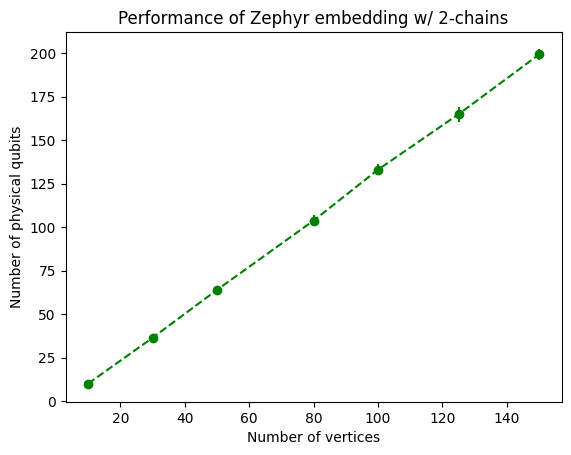

In [10]:
plt.errorbar(N_list, qubit_number_avg, yerr = qubit_number_std, fmt = 'o--', color = 'green')
plt.xlabel('Number of vertices')
plt.ylabel('Number of physical qubits')
plt.title('Performance of Zephyr embedding w/ {}-chains'.format(limit_chain_length))

This shows us that we can embed up to $300$ vertices in the Zephyr with $563$ physical qubits, though our requirement to have at most 2-chains is restrictive. For only 2-chains, we may need $N < 200$ Some large triangulations don't work as well! We may need 3-chains as well... This is interesting considerations. In essence, the larger the Zephyr **does not** mean we can easily do larger triangulations. It is the qubit connectivity that helps, and it is mainly due to the boundary of the triangulation. Forcing a denser boundary would help in embedding any size into larger and larger Zephyr, but that seems artificial.

# EX: constructing and running an embedding

construct a J and h dict:

In [104]:
Npts = 100
# a strange condition
beta = 1
h_val = 0.0
h_boundary = 0.0
Jval = -0.02
Kval = -2

#create graph
delaunay_graph = random_triangulation(Npts)
boundary_nodes, boundary_edge = find_edge_of_graph(delaunay_graph)

h_dict, J_dict, embedding = return_dicts(sampler, delaunay_graph, boundary_nodes, h_val, h_boundary, Jval, Kval, beta)

max chain length 2
2 good embedding


Perform a simple anneal forward, fixed anneal_time and number of reads. Save the data in a folder.

In [105]:
Nreads = 200
anneal_time = 100
response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                num_reads=Nreads,
                                                annealing_time=anneal_time,
                                                answer_mode="raw")

final_nodes=sorted(list(h_dict.keys()))
time = response.info['timing']['qpu_access_time']
resp = response.record 
variables = response.variables   
#save the response
paramsarray = set_params_array({
                'beta': beta,
                'Nreads': Nreads,
                'Npts' : Npts,
                'shim-or-measure' : 'measure',
                'anneal-time' : anneal_time,
                'runtime' : time,
                'answer_mode' :'raw',
                'id' : response.info['problem_id'],
                'h_bulk' : h_val,
                'h_boundary' : h_boundary,
                'Jval' : Jval
            })

folder = Path("./data/raw/Npts=" + str(Npts) + "/beta=" + str(beta) + "/" )
folder.mkdir(parents=True, exist_ok=True)
Name = 'forward_anneal_sol_' + response.info['problem_id']
filepath = Path(folder, Name)

#save the response
resp = response.record.sample
np.savez(
filepath,
resp=resp,
paramsarray=paramsarray,
final_nodes = final_nodes,
variables = variables,
embedding = embedding,
triangulation_nodes = delaunay_graph.nodes(),
triangulation_edges = delaunay_graph.edges()
)

print('done!')

done!


In [11]:
# dwave.inspector.show(response)

# Script to send all jobs

In [50]:
#saving
filepath = "./data/"

#anneal params
Nreads = 100
# anneal_time = 10
Nrep = 100
Nrep = 100
beta_range = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03, 0.01]
# beta_range = [1]

# Npts = 100
# a strange condition
h_val = 0.0
h_boundary = 0.0
Jval = -1
Kval = -2
Npts_range = [200, 300]

for Npts in Npts_range:
    
    for beta in beta_range:

        for rep in range(Nrep):

            #create graph
            delaunay_graph = random_triangulation(Npts)
            boundary_nodes, boundary_edge = find_edge_of_graph(delaunay_graph)

            h_dict, J_dict, embedding = return_dicts(sampler, delaunay_graph, boundary_nodes, h_val, h_boundary, Jval, Kval, beta)

            # print(h_dict)
            # print(J_dict)

            response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                            num_reads=Nreads,
                                                            annealing_time=anneal_time,
                                                            answer_mode="raw",
                                                            auto_scale = False)

            final_nodes=sorted(list(h_dict.keys()))
            time = response.info['timing']['qpu_access_time']
            resp = response.record 
            variables = response.variables   
            #save the response
            paramsarray = set_params_array({
                            'beta': beta,
                            'Nreads': Nreads,
                            'Npts' : Npts,
                            'shim-or-measure' : 'measure',
                            'anneal-time' : anneal_time,
                            'runtime' : time,
                            'answer_mode' :'raw',
                            'id' : response.info['problem_id'],
                            'h_bulk' : h_val,
                            'h_boundary' : h_boundary,
                            'Jval' : Jval
                        })

            folder = Path("./data/raw/Npts=" + str(Npts) + "/beta=" + str(beta) + "/" )
            folder.mkdir(parents=True, exist_ok=True)
            Name = 'forward_anneal_sol_' + str(rep)
            filepath = Path(folder, Name)

            #save the response
            resp = response.record.sample
            np.savez(
            filepath,
            resp=resp,
            paramsarray=paramsarray,
            final_nodes = final_nodes,
            variables = variables,
            embedding = embedding,
            triangulation_nodes = delaunay_graph.nodes(),
            triangulation_edges = delaunay_graph.edges()
            )

            print('done! Npts = {:.2f}, beta = {:.2f}, rep = {:.2f}'.format(Npts, beta, rep), flush = True)

2 bad embedding, 336 qubits used
3 bad embedding, 367 qubits used
4 bad embedding, 336 qubits used
5 bad embedding, 333 qubits used
6 good embedding, 291 qubits used
done! Npts = 200.00, beta = 0.50, rep = 0.00
2 bad embedding, 323 qubits used
3 good embedding, 279 qubits used
done! Npts = 200.00, beta = 0.50, rep = 1.00
2 good embedding, 284 qubits used
done! Npts = 200.00, beta = 0.50, rep = 2.00
2 good embedding, 288 qubits used
done! Npts = 200.00, beta = 0.50, rep = 3.00
2 bad embedding, 390 qubits used
3 bad embedding, 330 qubits used
4 bad embedding, 321 qubits used
5 bad embedding, 323 qubits used
6 good embedding, 273 qubits used
done! Npts = 200.00, beta = 0.50, rep = 4.00
2 bad embedding, 310 qubits used
3 bad embedding, 323 qubits used
4 bad embedding, 321 qubits used
5 bad embedding, 326 qubits used
6 good embedding, 287 qubits used
done! Npts = 200.00, beta = 0.50, rep = 5.00
2 good embedding, 279 qubits used
done! Npts = 200.00, beta = 0.50, rep = 6.00
2 bad embedding, 3